In [1]:
import numpy as np

import  matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt

import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pandas as pd

import scipy
from scipy import stats

import xarray as xa

In [2]:
all0205 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_200207-200505.nc", engine='netcdf4')
all0508 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_200506-200804.nc", engine='netcdf4')
all0811 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_200805-201103.nc", engine='netcdf4')
all1114 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_201104-201402.nc", engine='netcdf4')
all1417 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_201403-201701.nc", engine='netcdf4')
all1821 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_201702-201912.nc", engine='netcdf4')
all2123 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_202001-202211.nc", engine='netcdf4')
all2223 = xa.open_dataset("../daa/atropics/CERES_FluxByCldTyp-MON_Terra-Aqua-MODIS_Ed4.1_Subset_202212-202302.nc", engine='netcdf4')

In [3]:
var = "toa_lw"
alllw = xa.concat( [all0205[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all0508[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all0811[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all1114[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all1417[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all1821[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],
                    all2123[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_lw_clr_mon"]],], 
               dim='time')

In [4]:
var = "toa_sw"
allsw = xa.concat( [all0205[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all0508[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all0811[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all1114[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all1417[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all1821[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],
                    all2123[["cldarea_cldtyp_mon", f"{var}_cldtyp_mon", "toa_sw_clr_mon"]],], 
               dim='time')

In [5]:
#0
trop = slice(-30,30)
ragutime = slice('2006-06-15T00:00:00.000000000','2020-12-15T00:00:00.000000000' )

In [7]:
RclrLW_trop = alllw.sel(lat=trop,).toa_lw_clr_mon.mean("lon")
RovcLW_trop = alllw.sel(lat=trop,).toa_lw_cldtyp_mon.mean("lon")
lwK_trop = (RclrLW_trop - RovcLW_trop)/100

In [8]:
RclrSW_trop = allsw.sel(lat=trop,).toa_sw_clr_mon.mean("lon")
RovcSW_trop = allsw.sel(lat=trop,).toa_sw_cldtyp_mon.mean("lon")
swK_trop = (RclrSW_trop - RovcSW_trop)/100

In [9]:
#1d
K_trop = lwK_trop + swK_trop
K_trop

<xarray.DataArray (time: 245, lat: 60, opt: 6, press: 7)>
array([[[[-6.95322827e-02,  3.64839882e-02,  8.21122974e-02, ...,
           2.25793272e-01,  2.04872966e-01,  7.49827921e-02],
         [-1.62981927e-01, -6.67938590e-02,  3.76801491e-02, ...,
           3.13377500e-01,  4.12711978e-01,  3.57284546e-01],
         [-3.40756178e-01, -2.39068091e-01, -9.13528800e-02, ...,
           2.37454534e-01,  4.44557786e-01,             nan],
         [-5.62052011e-01, -4.30202931e-01, -2.85203397e-01, ...,
           5.42105436e-02,  2.92046666e-01,             nan],
         [-7.38983631e-01, -5.92498481e-01, -4.67242599e-01, ...,
          -9.60992575e-02,  1.48593426e-01,             nan],
         [-8.96904230e-01, -7.89884746e-01, -6.86066270e-01, ...,
          -2.32035637e-01,  6.15028143e-02,  3.62516999e-01]],

        [[-6.88544065e-02,  4.08401489e-02,  8.98803324e-02, ...,
           2.18167841e-01,  2.13180110e-01,  5.63667268e-02],
         [-1.70478523e-01, -6.60903454e-02,  3.68929505e-02, ...,
           3.18872720e-01,  4.23389077e-01,  1.86389953e-01],
         [-3.47768605e-01, -2.52343833e-01, -1.08421326e-01, ...,
           2.30587900e-01,  4.48855877e-01,             nan],
         [-5.74028909e-01, -4.45169687e-01, -3.01013947e-01, ...,
...
         [-5.82111537e-01, -4.98412758e-01, -3.26893866e-01, ...,
           1.11913681e-03,  2.41732001e-01,  4.70397115e-01],
         [-7.99845815e-01, -7.32915401e-01, -5.89658499e-01, ...,
          -2.09071517e-01,  6.41882420e-02,  3.20290089e-01],
         [-9.24576044e-01, -9.45141196e-01, -8.53852153e-01, ...,
          -4.16347384e-01, -8.28236341e-02,  1.66533470e-01]],

        [[-7.22350702e-02,  4.07077000e-02,  1.30738556e-01, ...,
           2.79527307e-01,  2.94779956e-01,  1.38402551e-01],
         [-1.86277747e-01, -5.88327497e-02,  8.49535763e-02, ...,
           3.26824635e-01,  4.33601975e-01,  4.36097473e-01],
         [-3.72210056e-01, -2.52781689e-01, -7.91501105e-02, ...,
           2.37427354e-01,  4.28874135e-01,  5.71606338e-01],
         [-5.75998962e-01, -4.85330641e-01, -2.98500687e-01, ...,
           9.08660889e-03,  2.44655848e-01,  4.12350535e-01],
         [-7.88951576e-01, -6.95055664e-01, -5.58004618e-01, ...,
          -1.87920213e-01,  7.74780512e-02,  3.48832726e-01],
         [-9.58500028e-01, -9.16851342e-01, -7.96981931e-01, ...,
          -3.94328713e-01, -4.34646606e-02,  1.93887115e-01]]]],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-15 2002-08-15 ... 2022-11-15
  * lat      (lat) float32 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
  * press    (press) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0
  * opt      (opt) float32 0.0 1.0 2.0 3.0 4.0 5.0

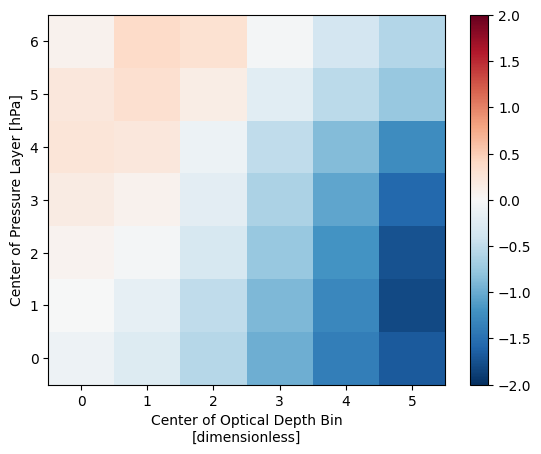

In [10]:
K_trop.sel(time=ragutime).mean(["lat","time"]).transpose().plot(vmin=-2.0, vmax=2.0, cmap="RdBu_r")

In [11]:
#2
area_trop = alllw.cldarea_cldtyp_mon.sel(lat=trop, time=ragutime).mean("lon")
cc_trop_anom = area_trop.groupby('time.month')- area_trop.groupby('time.month').mean('time')

In [12]:
#3
lwR_trop = lwK_trop*cc_trop_anom
swR_trop = swK_trop*cc_trop_anom

In [13]:
#4
lwR_trop_mean = lwR_trop.mean(['lat'])
swR_trop_mean = swR_trop.mean(['lat'])

In [14]:
#5
st_global_anom_raghu = xa.open_dataset("../daa/gistemp1200_GHCNv4_ERSSTv5.nc").sel(time=ragutime).tempanomaly
gmst_anom_raghu = st_global_anom_raghu.mean(["lat", "lon"])
gmst_anom_raghu 

<xarray.DataArray 'tempanomaly' (time: 175)>
array([0.7340974 , 0.23327379, 0.95729756, 0.8614268 , 0.7519227 ,
       1.0922004 , 0.8929325 , 1.352061  , 0.81504446, 0.836583  ,
       1.0926229 , 0.87418526, 0.88721585, 0.81538546, 0.8026729 ,
       0.74833465, 0.78329533, 0.9279178 , 0.7491277 , 0.4308684 ,
       0.57933533, 0.8252324 , 0.76213413, 0.5808064 , 0.5128105 ,
       0.73623   , 0.23524523, 1.0493329 , 0.85042876, 0.897696  ,
       0.7350532 , 1.0022017 , 0.35257638, 0.4691111 , 0.53939843,
       0.8555002 , 0.60499626, 1.013537  , 0.6357572 , 0.8434752 ,
       0.8893668 , 1.2145516 , 1.0211686 , 0.9557888 , 1.0947794 ,
       1.2157406 , 1.0138409 , 0.95631033, 0.52678865, 0.5167096 ,
       0.75278026, 0.72439295, 1.0713508 , 1.1212677 , 0.7554194 ,
       0.9791476 , 0.8346643 , 1.1364185 , 0.6974942 , 0.61308104,
       0.73563844, 1.0516075 , 1.20542   , 0.64237183, 1.040495  ,
       1.1222516 , 0.9874921 , 0.741593  , 1.0008649 , 0.8086605 ,
       0.8067767 , 0.94092107, 0.59838474, 0.5052733 , 0.62883955,
       0.9030482 , 1.2009776 , 1.2291529 , 1.0252488 , 1.070745  ,
       0.41058978, 0.9647237 , 0.53505075, 0.4117598 , 0.8525466 ,
       0.53505576, 0.90635866, 1.2488089 , 0.8892305 , 1.1433235 ,
       1.0008904 , 1.0251968 , 0.87810683, 1.0118538 , 0.8973033 ,
       1.1997538 , 0.5171232 , 0.28966346, 1.0284582 , 1.27745   ,
       1.0165708 , 0.7508415 , 0.9387355 , 1.009296  , 1.0470483 ,
       1.1734626 , 0.82906574, 0.54116184, 0.6770232 , 0.467253  ,
       0.54045945, 0.6877988 , 1.3617765 , 1.3410127 , 1.1787759 ,
       1.5683585 , 1.6426196 , 1.5635158 , 1.0774184 , 1.084393  ,
       0.63541967, 0.7580301 , 1.2751191 , 1.0135058 , 1.3459395 ,
       1.6724263 , 1.236167  , 1.3205633 , 1.5236497 , 1.5926498 ,
       1.0683384 , 1.0246125 , 0.4507032 , 0.67102385, 0.865965  ,
       0.6286322 , 1.2118883 , 1.2656969 , 1.3161578 , 1.155193  ,
       1.3502097 , 1.1059822 , 0.99785405, 0.7904572 , 0.8272059 ,
       0.83624786, 0.8844463 , 0.78497994, 1.5440823 , 1.0414176 ,
       1.2594701 , 0.8982021 , 1.268688  , 1.591518  , 1.1411424 ,
       1.0027951 , 0.8239294 , 1.061956  , 1.1055168 , 1.1121824 ,
       1.4073085 , 1.282054  , 1.3524693 , 1.1168512 , 1.4573159 ,
       1.2325764 , 1.6206894 , 1.2819471 , 1.0475671 , 0.94187945,
       0.83421904, 1.2312609 , 1.1837292 , 1.7534827 , 1.0458105 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2006-06-15 2006-07-15 ... 2020-12-15

In [15]:
#6
lw_feed =  np.zeros([7,6])
for od in [0,1,2,3,4,5]:
    for p in [0,1,2,3,4,5,6]:
        bint = lwR_trop_mean.sel(press=p, opt=od)
        regress = stats.linregress(gmst_anom_raghu, bint).slope
        lw_feed[p, od] = regress

lwfeed_trops = xa.DataArray(lw_feed, 
                    coords={"press": lwR_trop_mean.press, "opt":lwR_trop_mean.opt, 
                           },
                   )

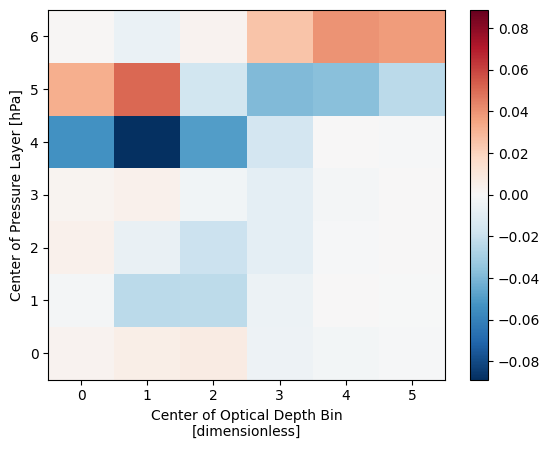

In [17]:
lwfeed_trops.plot()

In [16]:
#6
swR_trop = swK_trop*cc_trop_anom
swR_trop_mean = swR_trop.mean(['lat'])
sw_feed =  np.zeros([7,6])
for od in [0,1,2,3,4,5]:
    for p in [0,1,2,3,4,5,6]:
        bints = swR_trop_mean.sel(press=p, opt=od)
        sw_regress = stats.linregress(gmst_anom_raghu, bints).slope
        sw_feed[p, od] = sw_regress

swfeed_trops = xa.DataArray(sw_feed, 
                    coords={"press": swR_trop_mean.press, "opt":swR_trop_mean.opt, 
                           },
                   )

<xarray.DataArray ()>
array(0.00686013)


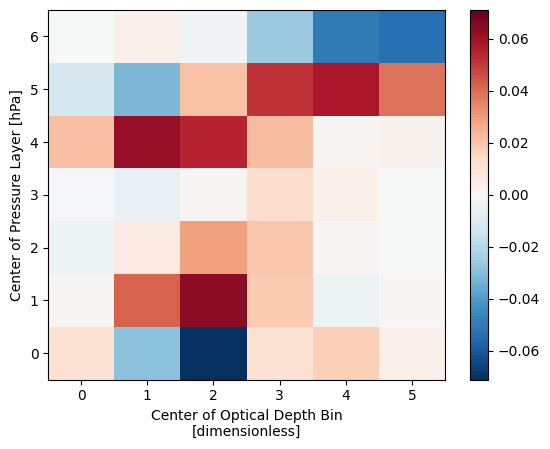

In [18]:
print(swfeed_trops.mean(["press", "opt"]))
(swfeed_trops).plot()

<xarray.DataArray ()>
array(0.00151866)


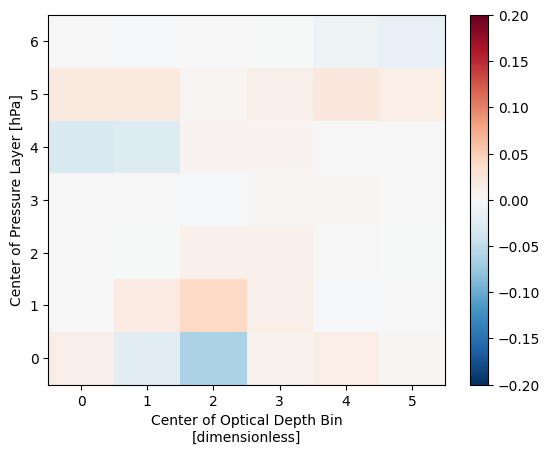

In [19]:
netfeed_trops = swfeed_trops + lwfeed_trops
print(netfeed_trops.mean(["press", "opt"]))
netfeed_trops.plot(vmin=-0.2, vmax=0.2, cmap="RdBu_r")